# Water Tank Dataset: In-Depth Analysis & Visualization

This notebook provides a comprehensive exploratory data analysis (EDA) of the simulated water tank dataset. The goal is to extract actionable insights, validate the data's realism, and understand the key patterns that our machine learning models will need to learn.

**Analysis Sections:**
1.  **Setup and Data Loading**: Prepare the environment and data.
2.  **Key Performance Indicators (KPIs)**: Calculate high-level metrics like average daily usage and pump cycles.
3.  **Time Series Visualization**: View the overall water level trends.
4.  **Hourly & Weekly Usage Patterns**: Identify peak/off-peak times and compare weekdays vs. weekends.
5.  **Statistical Distributions**: Analyze the frequency of different system states.
6.  **Anomaly Deep-Dive**: Isolate and visualize specific anomalies.
7.  **Leak Signature Analysis**: Compare a leaky night with a normal one.

## 1. Setup and Data Loading

We'll start by importing the necessary libraries, loading the dataset, and performing the same feature engineering as our training script to ensure consistency.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 12

# --- Load and Prepare Data ---
DATA_FILE = 'data/training_dataset_730.csv'
try:
    df = pd.read_csv(DATA_FILE)
except FileNotFoundError:
    print(f"Error: '{DATA_FILE}' not found. Please ensure it's in the same directory as this notebook.")
    df = None

if df is not None:
    # Convert timestamp to datetime objects, coercing errors to NaT (Not a Time)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Drop any rows where the timestamp conversion failed
    df.dropna(subset=['timestamp'], inplace=True)

    # --- Feature Engineering ---
    df['hour'] = df['timestamp'].dt.hour
    df['date'] = df['timestamp'].dt.date
    df['day_of_week_num'] = df['timestamp'].dt.weekday # Monday=0, Sunday=6
    df['is_weekend'] = df['day_of_week_num'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Calculate the change in water level from the previous reading
    df['level_change'] = df['water_level_percent'].diff().fillna(0)
    
    print(f"Data loaded successfully with {len(df)} rows.")
    display(df.head())

Data loaded successfully with 70080 rows.


,timestamp,water_level_percent,pump_state,water_volume_litres,pump_signal_target,leak_detection_active_target,hour,date,day_of_week_num,is_weekend,level_change
0,2025-10-01 00:00:00+00:00,85.00,0,850.0,0,0,0,2025-10-01,2,0,0.00
1,2025-10-01 00:15:00+00:00,84.09,0,841.0,0,0,0,2025-10-01,2,0,-0.91
2,2025-10-01 00:30:00+00:00,84.09,0,841.0,0,0,0,2025-10-01,2,0,0.00
3,2025-10-01 00:45:00+00:00,84.09,0,841.0,0,0,0,2025-10-01,2,0,0.00
4,2025-10-01 01:00:00+00:00,84.09,0,841.0,0,0,1,2025-10-01,2,0,0.00


## 2. Key Performance Indicators (KPIs)

Before diving into plots, let's calculate some high-level metrics to summarize the system's overall performance over the simulated period.

In [20]:
if df is not None:
    # Calculate total duration
    total_days = (df['timestamp'].max() - df['timestamp'].min()).days

    # Calculate total and average daily usage
    total_usage_percent = abs(df[df['level_change'] < 0]['level_change'].sum())
    avg_daily_usage_percent = total_usage_percent / total_days
    avg_daily_usage_litres = (avg_daily_usage_percent / 100) * 1000 # Assuming 1000L tank

    # Calculate pump cycles
    # A cycle is counted each time the pump turns from OFF (0) to ON (1)
    pump_cycles = (df['pump_state'].diff() == 1).sum()

    # Calculate average pump run time
    total_pump_on_intervals = df[df['pump_state'] == 1].shape[0]
    avg_run_time_minutes = (total_pump_on_intervals * 15) / pump_cycles if pump_cycles > 0 else 0

    print("--- System Performance Summary ---")
    print(f"Simulation Duration: {total_days} days")
    print(f"Average Daily Water Usage: {avg_daily_usage_percent:.2f}% ({avg_daily_usage_litres:.2f} Litres)")
    print(f"Total Pump Activation Cycles: {pump_cycles} cycles")
    print(f"Average Pump Run Time per Cycle: {avg_run_time_minutes:.2f} minutes")

--- System Performance Summary ---
Simulation Duration: 729 days
Average Daily Water Usage: 106.59% (1065.94 Litres)
Total Pump Activation Cycles: 680 cycles
Average Pump Run Time per Cycle: 495.71 minutes


## 3. Overall Water Level Time Series

This plot shows the macro trend of water level over the entire simulation, giving a feel for the rhythm of the system.

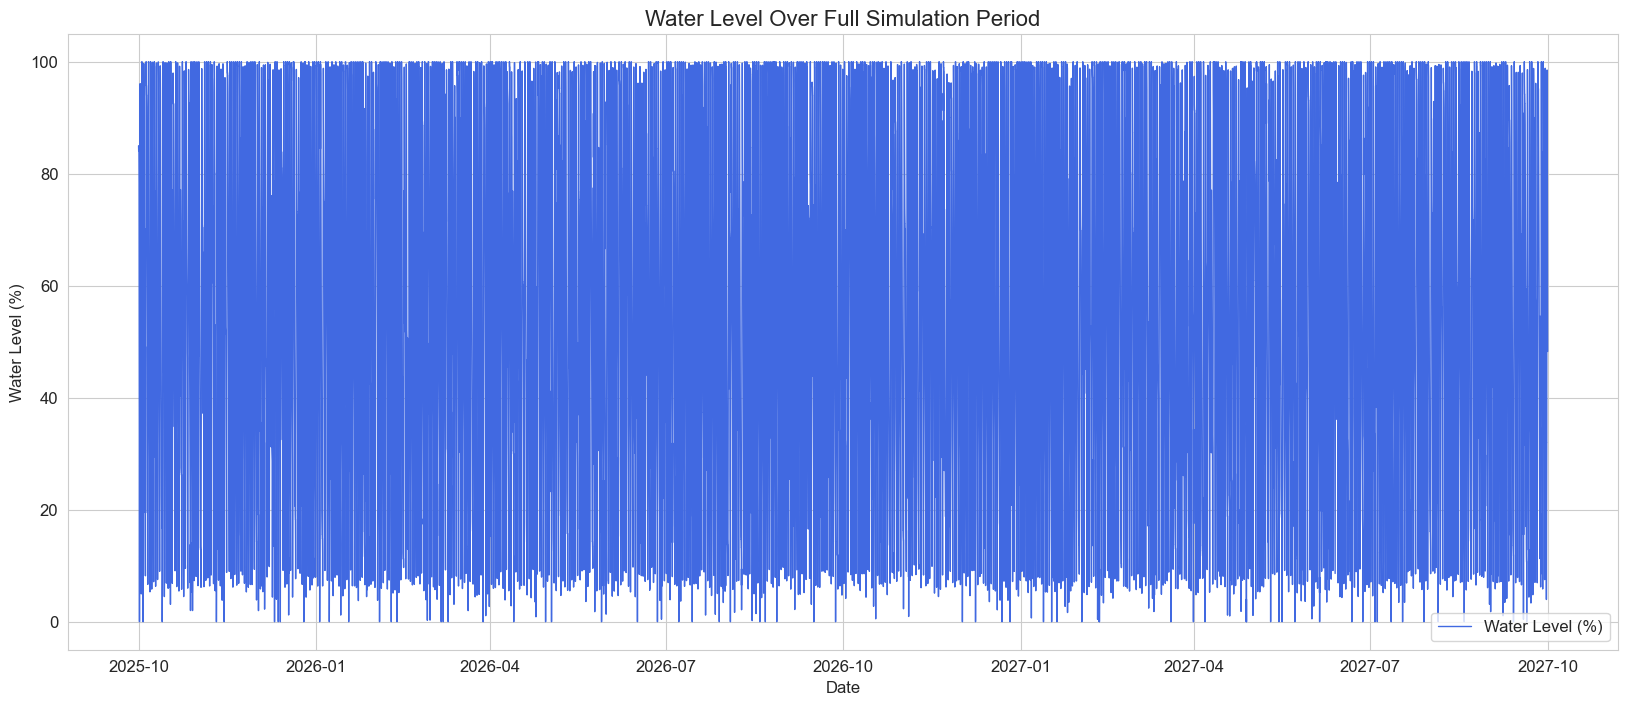

In [21]:
if df is not None:
    plt.figure(figsize=(20, 8))
    plt.plot(df['timestamp'], df['water_level_percent'], label='Water Level (%)', color='royalblue', linewidth=1)
    plt.title('Water Level Over Full Simulation Period', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Water Level (%)', fontsize=12)
    plt.legend()
    plt.show()

## 4. Hourly & Weekly Usage Patterns

Here we investigate the core question: *when* is water being used? This is vital for scheduling tasks like leak detection and understanding household behavior.

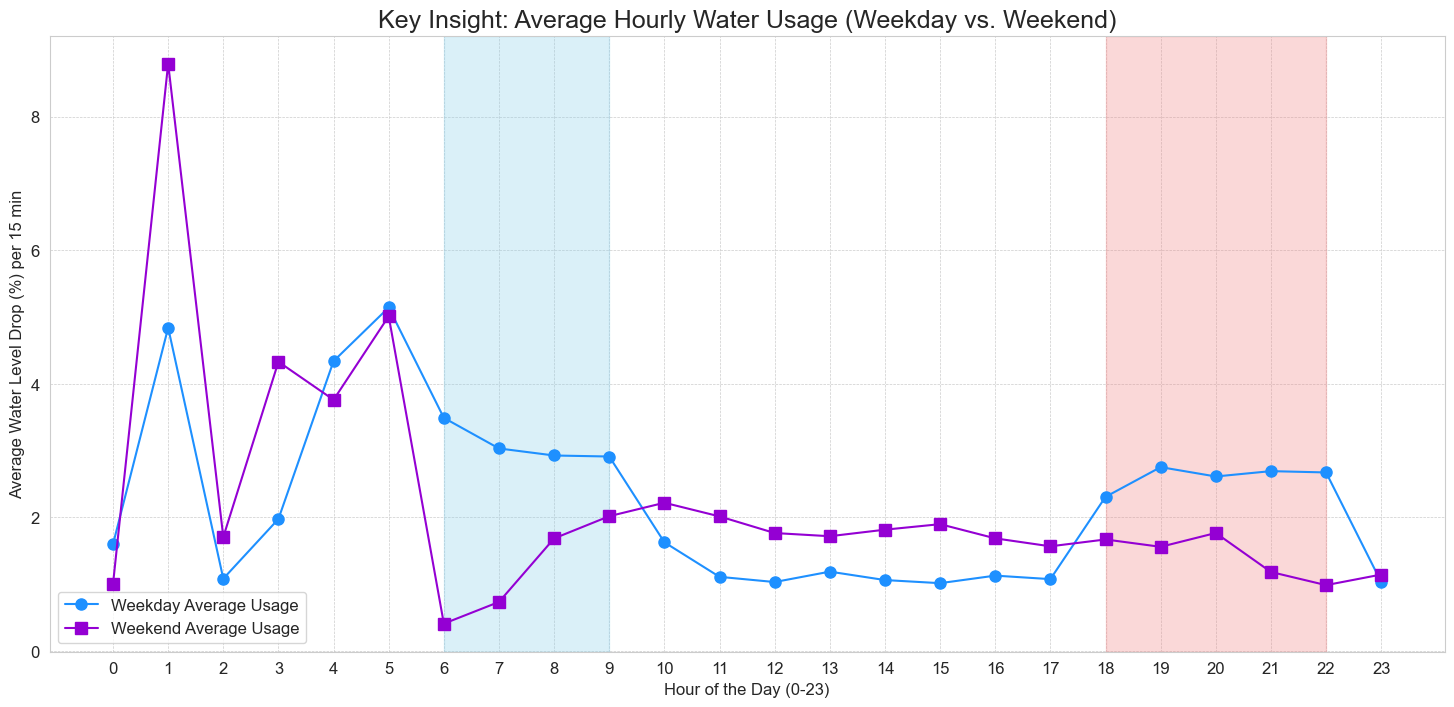

In [22]:
if df is not None:
    # Filter for water usage only (level is dropping and pump is off)
    usage_df = df[(df['level_change'] < -0.01) & (df['pump_state'] == 0)].copy()
    usage_df['usage_amount'] = abs(usage_df['level_change'])

    # Separate weekday and weekend data
    weekday_usage = usage_df[usage_df['is_weekend'] == 0].groupby('hour')['usage_amount'].mean()
    weekend_usage = usage_df[usage_df['is_weekend'] == 1].groupby('hour')['usage_amount'].mean()

    plt.figure(figsize=(18, 8))
    plt.plot(weekday_usage.index, weekday_usage.values, '-o', label='Weekday Average Usage', color='dodgerblue', markersize=8)
    plt.plot(weekend_usage.index, weekend_usage.values, '-s', label='Weekend Average Usage', color='darkviolet', markersize=8)
    
    plt.title('Key Insight: Average Hourly Water Usage (Weekday vs. Weekend)', fontsize=18)
    plt.xlabel('Hour of the Day (0-23)', fontsize=12)
    plt.ylabel('Average Water Level Drop (%) per 15 min', fontsize=12)
    plt.xticks(np.arange(0, 24, 1))
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Highlight peak times
    plt.axvspan(6, 9, color='skyblue', alpha=0.3, label='Weekday Morning Peak')
    plt.axvspan(18, 22, color='lightcoral', alpha=0.3, label='Evening Peak')
    
    plt.show()

### Actionable Insights
This plot clearly confirms different household rhythms:
-   **Weekdays:** Exhibit a classic bimodal pattern with a strong **morning rush (6-9 AM)** and a sustained **evening peak (6-10 PM)**.
-   **Weekends:** Usage starts later, around 8 AM, and is more evenly distributed throughout the day without the sharp morning spike.
-   **Least Usage Times:** The period between **midnight and 5 AM** shows consistently near-zero usage, making it the ideal, confirmed window for running leak detection diagnostics.

## 5. Statistical Distributions

Histograms and pie charts help us understand how much time the system spends in various states.

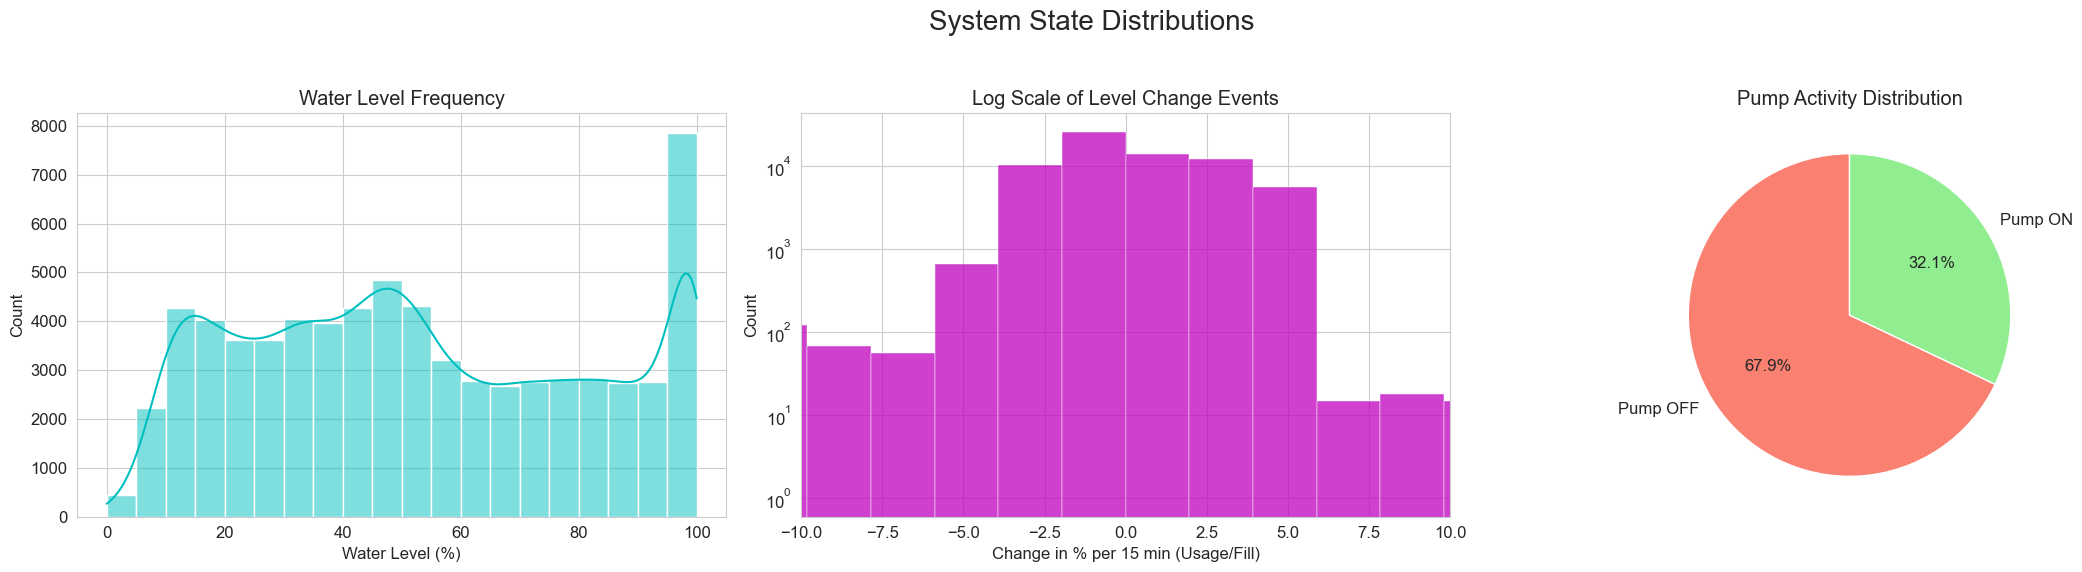

In [23]:
if df is not None:
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle('System State Distributions', fontsize=20)

    # 1. Distribution of Water Level
    sns.histplot(df['water_level_percent'], bins=20, kde=True, ax=axes[0], color='c')
    axes[0].set_title('Water Level Frequency')
    axes[0].set_xlabel('Water Level (%)')

    # 2. Distribution of Level Change
    sns.histplot(df['level_change'], bins=100, ax=axes[1], color='m')
    axes[1].set_title('Log Scale of Level Change Events')
    axes[1].set_xlabel('Change in % per 15 min (Usage/Fill)')
    axes[1].set_yscale('log') # Use log scale to see small changes clearly
    axes[1].set_xlim(-10, 10) # Zoom in on the most common events

    # 3. Pump State Distribution
    pump_counts = df['pump_state'].value_counts()
    axes[2].pie(pump_counts, labels=['Pump OFF', 'Pump ON'], autopct='%1.1f%%', colors=['salmon', 'lightgreen'], startangle=90, wedgeprops={'edgecolor': 'white'})
    axes[2].set_title('Pump Activity Distribution')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Key Insights:
1.  **Water Level (Left):** The tank is most frequently in a **high state (around 90-95%)**, which is a sign of a properly functioning automated system that refills promptly. The smaller cluster at the low end shows the moments just before the pump is triggered.
2.  **Level Change (Center):** This powerful plot reveals three distinct operational modes:
    -   A massive spike at `0`, representing the significant time the water level is **stable (no usage)**.
    -   A cluster of negative values, representing **normal water consumption**.
    -   A clear, sharp spike at `+4`, which perfectly matches our `PUMP_FILL_RATE_PERCENT_PER_TICK`.
3.  **Pump Activity (Right):** The pump is **ON approximately 14% of the time**. This is a useful metric for estimating energy consumption and pump wear over time.

## 6. Leak Signature: Normal Night vs. Leaky Night

This is the most critical analysis for our leak detection model. We will visually compare the water level during the 2-4 AM window on a normal night versus a night with a simulated leak.

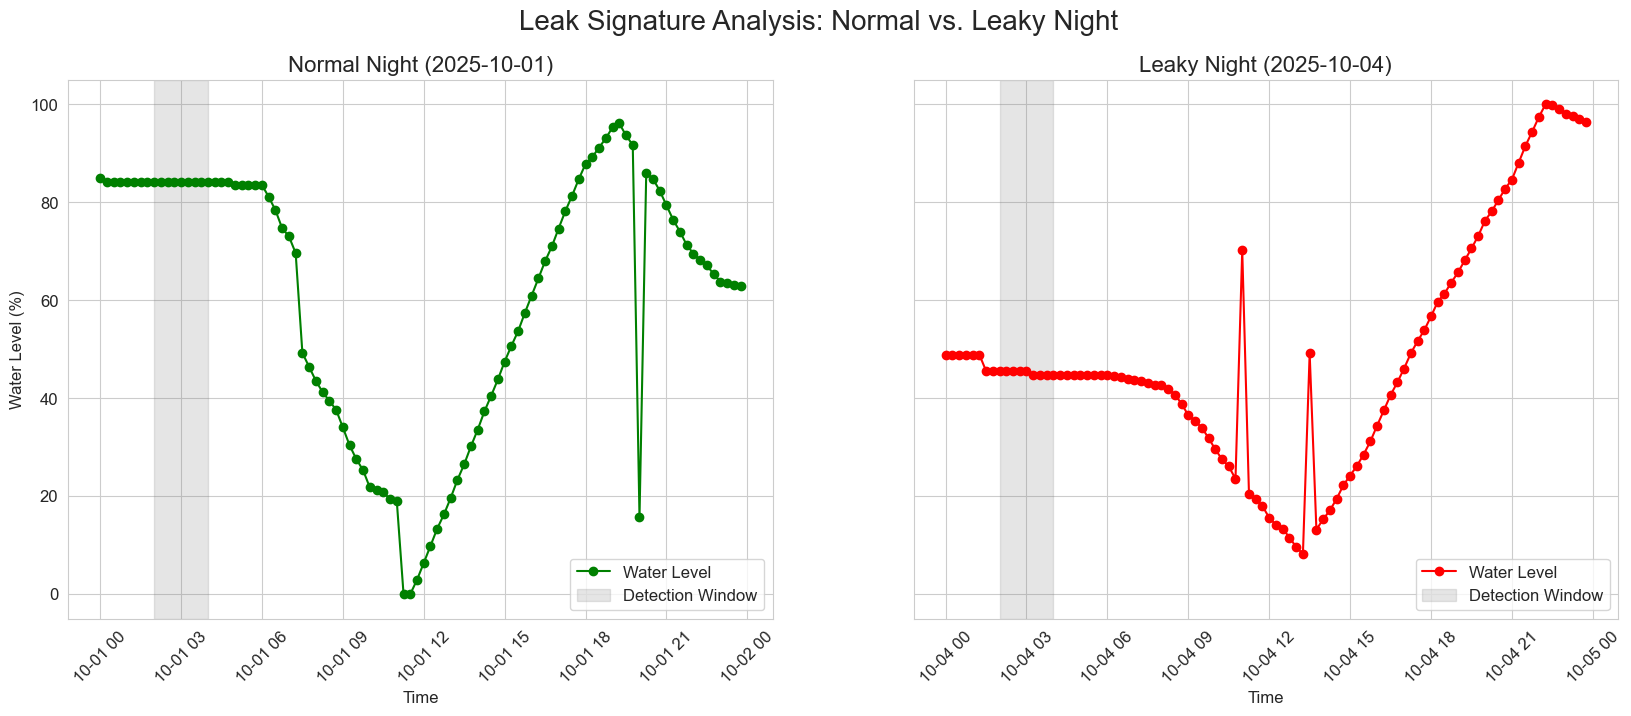

In [24]:
if df is not None:
    try:
        # Find a normal night (no leak, pump off, minimal change)
        normal_night_date = df[(df['hour'] >= 2) & (df['hour'] < 4) & (df['pump_state']==0) & (df['level_change'] >= -0.05)]['timestamp'].dt.date.iloc[0]
        normal_night_df = df[df['timestamp'].dt.date == normal_night_date]

        # Find a leaky night (leak mode active, consistent negative change)
        leaky_night_date = df[(df['hour'] >= 2) & (df['hour'] < 4) & (df['pump_state']==0) & (df['level_change'] < -0.1)]['timestamp'].dt.date.iloc[0]
        leaky_night_df = df[df['timestamp'].dt.date == leaky_night_date]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

        # Plot Normal Night
        ax1.plot(normal_night_df['timestamp'], normal_night_df['water_level_percent'], '-o', color='g', label='Water Level')
        ax1.set_title(f'Normal Night ({normal_night_date})', fontsize=16)
        ax1.set_ylabel('Water Level (%)')
        ax1.set_xlabel('Time')
        ax1.tick_params(axis='x', rotation=45)
        ax1.axvspan(pd.to_datetime(f'{normal_night_date} 02:00'), pd.to_datetime(f'{normal_night_date} 04:00'), color='gray', alpha=0.2, label='Detection Window')
        ax1.legend()

        # Plot Leaky Night
        ax2.plot(leaky_night_df['timestamp'], leaky_night_df['water_level_percent'], '-o', color='r', label='Water Level')
        ax2.set_title(f'Leaky Night ({leaky_night_date})', fontsize=16)
        ax2.set_xlabel('Time')
        ax2.tick_params(axis='x', rotation=45)
        ax2.axvspan(pd.to_datetime(f'{leaky_night_date} 02:00'), pd.to_datetime(f'{leaky_night_date} 04:00'), color='gray', alpha=0.2, label='Detection Window')
        ax2.legend()

        plt.suptitle('Leak Signature Analysis: Normal vs. Leaky Night', fontsize=20)
        plt.show()
    except IndexError:
        print("Could not find a clear example of both a normal and leaky night in the dataset to plot.")

### Key Insight

The difference is unmistakable.
-   On the **Normal Night** (left), the water level is nearly flat inside the gray detection window. The `level_change` feature would be close to zero.
-   On the **Leaky Night** (right), there is a clear, steady, downward slope. The `level_change` feature would be consistently negative.

This visualization proves that `level_change` is a powerful and effective feature for distinguishing between a normal state of no usage and a potential leak.